## RNN avec pytorch

Classification d’images par réseau de neurones profonds en utilisant la librairie PyTorch de Python.

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
import os
import time

### Imporation des données MNIST 

On utilisera la celèbre base de données mnist de:https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
Les images avec lesquelles nous allons travailler sont des images en noir et blanc de taille 28 x 28 pixels, soit 784 pixels au total. Nos caractéristiques seront les valeurs de chaque pixel. Soit le pixel est "blanc" (blanc avec un 0), soit il y a une valeur de pixel.
 

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...


/Users/vw12/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
dataset_size = len(dataset)
dataset_size

60000

In [5]:
classes = list(dataset.classes)
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
from collections import Counter

counter = Counter()
for img, label in dataset:
    counter[classes[label]] += 1

counter  

Counter({'5 - five': 5421,
         '0 - zero': 5923,
         '4 - four': 5842,
         '1 - one': 6742,
         '9 - nine': 5949,
         '2 - two': 5958,
         '3 - three': 6131,
         '6 - six': 5918,
         '7 - seven': 6265,
         '8 - eight': 5851})

Label: 5 - five


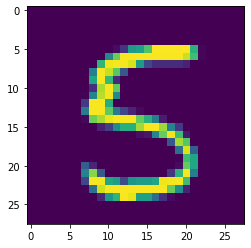

In [10]:
img, label = dataset[1340]
plt.imshow(np.squeeze(img))
print('Label:', classes[label])

In [25]:
img,lab =dataset[345]
img.shape

torch.Size([1, 28, 28])

## Processing
Création du jeu d’entrainement et de test, définition de la taille du batch pour entraîner le modèle et création des data loaders.

In [26]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [27]:
train_size

55000

In [28]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(55000, 5000)

In [29]:
batch_size=128

**pin_memory ( bool , en option )** - Si True, le chargeur de données copiera tenseurs dans la mémoire CUDA épinglé avant de les retourner. Si vos éléments de données sont de type personnalisé ou si vous collate_fnretournez un lot de type

**num_workers ( int , facultatif )** - combien de sous-processus à utiliser pour le chargement des données. 0signifie que les données seront chargées dans le processus principal. (par défaut: 0)

In [30]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


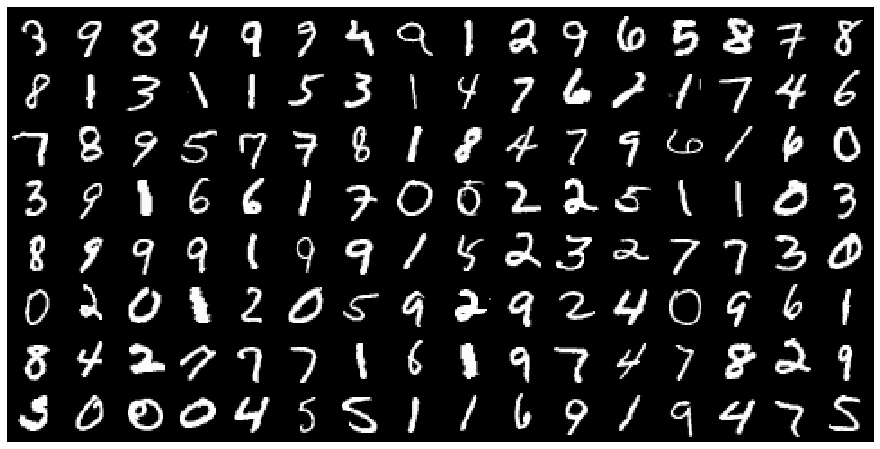

In [37]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

torch.device

## Création du modèle et utilisation de GPU
Construction de la classe ImageClassificationBase contenant les étapes du modèle et définition des fonctions.

In [39]:
# definition de l'accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    # on retourne le quodient de ceux qui sont bien classifiées sur nobre total
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [40]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [43]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Définissons d’autres fonctions pour afficher graphiquement les résultats.


In [44]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [45]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [47]:
len(train_loader)

430

## Entraînement du modèle
Création de la classe MnistModel pour compléter la classe ImageClassificationBase afin de l’adapter à notre situation. Nous avons 10 classes possibles et une taille d’image de (1*28*28). Nous choisissons d’utiliser 5 couches et de les activer avec une fonction d’action de type Relu.

In [48]:
input_size = 1*28*28
output_size = 10
input_size

784

In [50]:
class MnistModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512,256)
        self.linear3 = nn.Linear(256,128)
        self.linear4 = nn.Linear(128,64)
        self.linear5 = nn.Linear(64,output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)   
        out = self.linear4(out)
        out = F.relu(out)   
        out = self.linear5(out)
        return out

Instanciation du modèle et résultat sans entrainement.


In [52]:
#model = to_device(MnistModel(), device)
model = MnistModel()


In [53]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3057491779327393, 'val_acc': 0.09599034488201141}]

Entraînement du modèle et métriques


In [59]:
history += fit(20, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1107, val_acc: 0.9811
Epoch [1], val_loss: 0.1102, val_acc: 0.9809
Epoch [2], val_loss: 0.1119, val_acc: 0.9811
Epoch [3], val_loss: 0.1117, val_acc: 0.9811
Epoch [4], val_loss: 0.1135, val_acc: 0.9811
Epoch [5], val_loss: 0.1137, val_acc: 0.9815
Epoch [6], val_loss: 0.1147, val_acc: 0.9815
Epoch [7], val_loss: 0.1155, val_acc: 0.9817
Epoch [8], val_loss: 0.1165, val_acc: 0.9813
Epoch [9], val_loss: 0.1164, val_acc: 0.9817
Epoch [10], val_loss: 0.1170, val_acc: 0.9815
Epoch [11], val_loss: 0.1182, val_acc: 0.9813
Epoch [12], val_loss: 0.1183, val_acc: 0.9813
Epoch [13], val_loss: 0.1196, val_acc: 0.9817
Epoch [14], val_loss: 0.1198, val_acc: 0.9813
Epoch [15], val_loss: 0.1199, val_acc: 0.9813
Epoch [16], val_loss: 0.1207, val_acc: 0.9813
Epoch [17], val_loss: 0.1218, val_acc: 0.9817
Epoch [18], val_loss: 0.1215, val_acc: 0.9813
Epoch [19], val_loss: 0.1225, val_acc: 0.9813


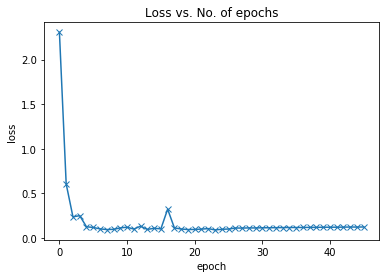

In [60]:
plot_losses(history)

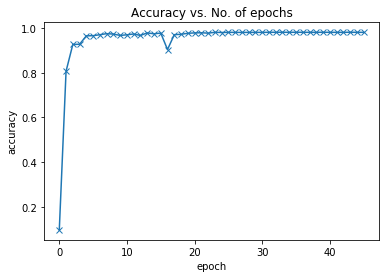

In [61]:
plot_accuracies(history)

In [62]:
evaluate(model,train_loader)

{'val_loss': 0.00010549725266173482, 'val_acc': 1.0}

In [64]:
evaluate(model,test_loader)

{'val_loss': 0.09852772951126099, 'val_acc': 0.98193359375}

In [65]:
evaluate(model,val_loader)

{'val_loss': 0.12249724566936493, 'val_acc': 0.9813189506530762}

In [66]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)